In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import itertools
import matplotlib
from numpy import argmax
from sklearn.metrics import precision_recall_curve
import pickle as pkl

In [2]:
os.getcwd() # Check current working directory

'C:\\Users\\HP'

In [3]:
os.chdir(r"D:\Notebooks_scripts\Models") # Change working directory

In [4]:
os.getcwd() # Check current working directory

'D:\\Notebooks_scripts\\Models'

# Data overview

In [5]:
# Import the data
data = pd.read_csv(r"D:\Notebooks_scripts\Models\Social_Network_Ads.csv")

In [6]:
data.shape # Check the number of rows and columns

(400, 5)

In [7]:
data.head(2) # Have a galnce at the data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0


In [8]:
data.columns = ["UserID", "Gender", "Age", "EstimatedSalary", "Purchased"]

In [9]:
data.columns

Index(['UserID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased'], dtype='object')

In [10]:
data.info() # Check the data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   UserID           400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [11]:
X = data[['UserID' , 'Gender', 'Age',  'EstimatedSalary']] # Separte explanatory variables
y = data[['UserID' , 'Purchased']] # Sepearte target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0) # Split into train and test set
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.25, random_state = 0) # Split into validation and test set

train = pd.merge(X_train, y_train, on = 'UserID') # Build train set
valid = pd.merge(X_valid, y_valid, on  = 'UserID') # Build validation set
test = pd.merge(X_test, y_test, on  = 'UserID') # Build test set


In [12]:
print(train.shape) # Check the size of the train set 
print(valid.shape) # Check the size of the valid set 
print(test.shape) # Check the size of the test set 

(320, 5)
(60, 5)
(20, 5)


In [13]:
train.describe(include = 'all')

,UserID,Gender,Age,EstimatedSalary,Purchased
count,3.200000e+02,320,320.00000,320.000000,320.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,164,NaN,NaN,NaN
mean,1.569120e+07,NaN,38.21875,69928.125000,0.378125
std,7.058254e+04,NaN,10.30304,34570.057299,0.485679
min,1.556964e+07,NaN,18.00000,15000.000000,0.000000
25%,1.562820e+07,NaN,30.00000,43000.000000,0.000000
50%,1.569434e+07,NaN,38.00000,69500.000000,0.000000
75%,1.574919e+07,NaN,46.00000,88000.000000,1.000000


In [14]:
train.isnull().sum() # Search for missing values

UserID             0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

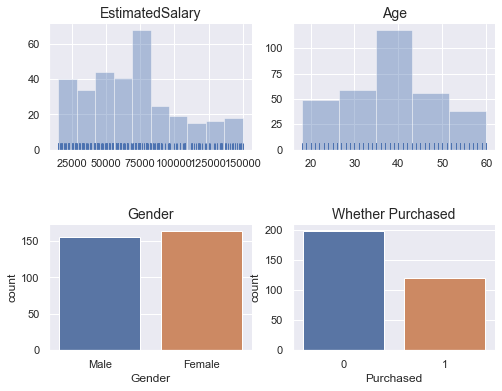

In [15]:
fig, axarr = plt.subplots(2, 2, figsize=(8, 6))
sns.distplot(train[['EstimatedSalary']],bins=10, kde=False, rug=True, ax=axarr[0][0]).set_title("EstimatedSalary", fontsize=14)
sns.distplot(train[['Age']],bins=5, kde=False, rug=True, ax=axarr[0][1]).set_title("Age", fontsize=14)
sns.countplot(x ='Gender', data = train, ax=axarr[1][0]).set_title("Gender", fontsize=14)
sns.countplot(x ='Purchased', data = train, ax=axarr[1][1]).set_title("Whether Purchased", fontsize=14)
plt.subplots_adjust(hspace=.6)
sns.despine()

In [16]:
train.Purchased.value_counts()/train.Purchased.count() # Check proportion of each classes of the target varibale in the data

0    0.621875
1    0.378125
Name: Purchased, dtype: float64

# Data exploration and feature creation

In [17]:
df = train

In [18]:
# Create a helper function to build histogram over the classes of the target variable
def prehist(x):
    yes = df[x][df['Purchased'] == 1]
    no = df[x][df['Purchased'] == 0]
    return yes, no

Text(0.5, 1.0, 'Age distribution over purchased status')

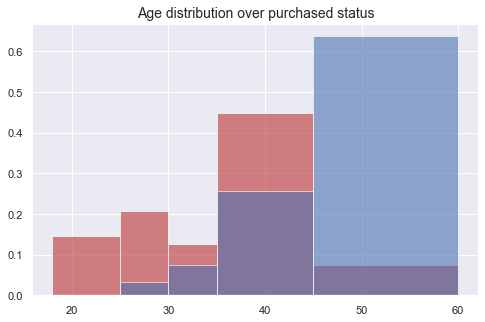

In [19]:
# Create a histogram of the age group of the users over the two classes of the target variable
plt.rcParams["figure.figsize"] = (8,5)
plt.hist(prehist('Age')[1], bins=[18, 25, 30, 35, 45, 60], 
         weights=np.ones(len(prehist('Age')[1])) / len(prehist('Age')[1]), alpha=0.7, label='no', color='r')
plt.hist(prehist('Age')[0], bins=[18, 25, 30, 35, 45, 60], 
         weights=np.ones(len(prehist('Age')[0])) / len(prehist('Age')[0]),alpha=0.6, label='yes', color='b')
plt.title("Age distribution over purchased status", fontsize=14)

In [20]:
# Create a helper function for the age buckets
def age_group(df) :
    
    if (df['Age'] >= 18) & (df['Age'] <= 25 ) :
        return "18-25"
    elif (df['Age'] > 25) & (df['Age'] <= 30 ) :
        return "25-30"
    elif (df['Age'] > 30) & (df['Age'] <= 35 ) :
        return "30-35"
    elif (df['Age'] > 35) & (df['Age'] <= 45 ) :
        return "35-45"
    elif df['Age'] > 45 :
        return "45-60"   
    
# Create the age buckets from the age of the users
df["age_group"] = df.apply(lambda y:age_group(y), axis = 1)

(array([0.0661157 , 0.1322314 , 0.07438017, 0.04958678, 0.00826446,
        0.10743802, 0.11570248, 0.17355372, 0.27272727]),
 array([ 15000,  25000,  35000,  45000,  55000,  65000,  85000, 100000,
        120000, 150000]),
 <a list of 9 Patch objects>)

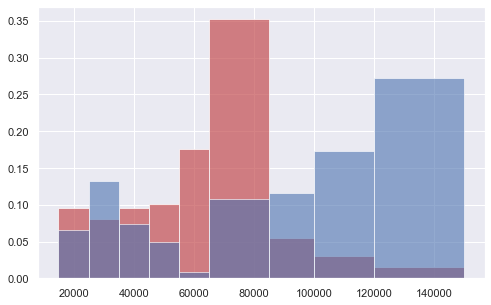

In [21]:
# Create a histogram of the estimated salalies of the users over the two classes of the target variable

plt.rcParams["figure.figsize"] = (8,5)
plt.hist(prehist('EstimatedSalary')[1], bins=[15000, 25000, 35000, 45000, 55000, 65000, 85000, 100000, 120000,150000], 
         weights=np.ones(len(prehist('EstimatedSalary')[1])) / len(prehist('EstimatedSalary')[1]), alpha=0.7, label='no', color='r')
plt.hist(prehist('EstimatedSalary')[0], bins=[15000, 25000, 35000, 45000, 55000, 65000, 85000, 100000, 120000, 150000], 
         weights=np.ones(len(prehist('EstimatedSalary')[0])) / len(prehist('EstimatedSalary')[0]),alpha=0.6, label='yes', color='b')

In [22]:
# Create a helper function for the salary buckets
def salary_group(df) :
    
    if (df['EstimatedSalary'] >= 15000) & (df['EstimatedSalary'] <= 25000 ) :
        return "15000-25000"
    elif (df['EstimatedSalary'] > 25000) & (df['EstimatedSalary'] <= 35000 ) :
        return "25000-35000"
    elif (df['EstimatedSalary'] > 35000) & (df['EstimatedSalary'] <= 45000 ) :
        return "35000-45000"
    elif (df['EstimatedSalary'] > 45000) & (df['EstimatedSalary'] <= 55000) :
        return "45000-55000"
    elif (df['EstimatedSalary'] > 55000) & (df['EstimatedSalary'] <= 65000) :
        return "55000-65000"
    elif (df['EstimatedSalary'] > 65000) & (df['EstimatedSalary'] <= 85000) :
        return "65000-85000"
    elif (df['EstimatedSalary'] > 85000) & (df['EstimatedSalary'] <= 100000) :
        return "85000-100000"
    elif (df['EstimatedSalary'] > 100000) & (df['EstimatedSalary'] <= 120000) :
        return "100000-120000"
    elif (df['EstimatedSalary'] > 120000) & (df['EstimatedSalary'] <= 150000) :
        return "120000-150000"
    
# Create the salary buckets from the estimated salary of the users
df["salary_group"] = df.apply(lambda y:salary_group(y), axis = 1)

In [23]:
# Find the gender distribution in each classes of the target variable
lab_0 = df["Gender"][df['Purchased'] == 0].value_counts().keys().tolist()
val_0 = df["Gender"][df['Purchased'] == 0].value_counts().values.tolist()
lab_1 = df["Gender"][df['Purchased'] == 1].value_counts().keys().tolist()
val_1 = df["Gender"][df['Purchased'] == 1].value_counts().values.tolist()

Text(0.5, 1.0, 'Gender distribution in Purchased')

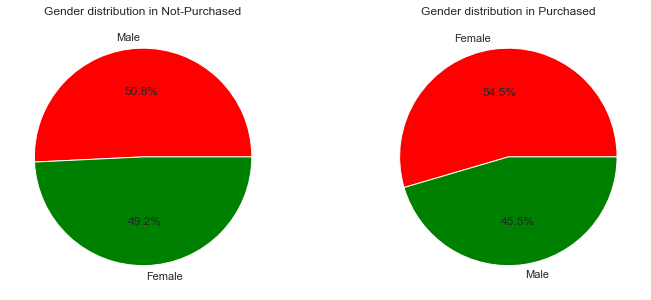

In [24]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
# Crate a pie chart for the gender distribution of the Not-Purchased class
axarr[0].pie(val_0, labels=lab_0, colors=['red','green'], autopct='%1.1f%%')
axarr[0].set_title("Gender distribution in Not-Purchased")

# Crate a pie chart for the gender distribution of the Purchased class
axarr[1].pie(val_1, labels=lab_1, colors=['red','green'], autopct='%1.1f%%')
axarr[1].set_title("Gender distribution in Purchased")

In [26]:
df.head(2) # Have a look on the modified train set

,UserID,Gender,Age,EstimatedSalary,Purchased,age_group,salary_group
0,15664907,Male,58,144000,1,45-60,120000-150000
1,15605000,Female,59,83000,0,45-60,65000-85000


In [27]:
# Select age_group and salary_group instead of Age and EstimatedSalary 
df1 = df[['UserID', 'Gender', 'age_group', 'salary_group', 'Purchased']] 

In [28]:
# Create dummy variables for the each busckts of the age_group and salary_group variables
df1 = pd.get_dummies(df1, drop_first=True) 

In [29]:
# Calculate the correlation matrix among the modified explanatory variables

data_cor = df1[[ 'Gender_Male', 'age_group_25-30',
       'age_group_30-35', 'age_group_35-45', 'age_group_45-60',
       'salary_group_120000-150000', 'salary_group_15000-25000',
       'salary_group_25000-35000', 'salary_group_35000-45000',
       'salary_group_45000-55000', 'salary_group_55000-65000',
       'salary_group_65000-85000', 'salary_group_85000-100000']]

corrmat = data_cor.corr()

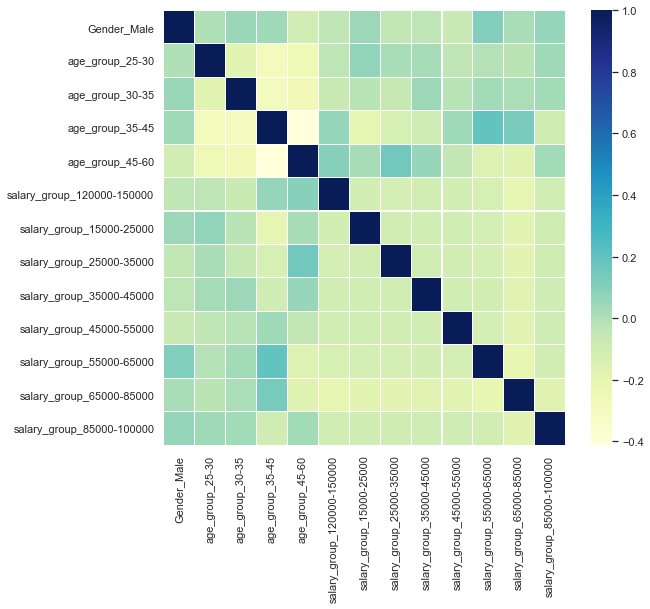

In [30]:
# Plot the correlation among the modified explanatory variables
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [31]:
train = df1 # Rename the modified train set

In [32]:
train.shape # Recheck the size of the train set

(320, 15)

# Feature creation for test and the validation data 

In [33]:
valid["age_group"] = valid.apply(lambda y:age_group(y), axis = 1) # create age buckets for the validation set
test["age_group"] = test.apply(lambda y:age_group(y), axis = 1) # create age buckets for the test set

In [34]:
valid.shape

(60, 6)

In [35]:
test.shape

(20, 6)

In [36]:
valid["salary_group"] = valid.apply(lambda y:salary_group(y), axis = 1) # Create salary buckets for the validation set
test["salary_group"] = test.apply(lambda y:salary_group(y), axis = 1) # Create salary buckets for the test set

In [37]:
valid.nunique()

UserID             60
Gender              2
Age                29
EstimatedSalary    45
Purchased           2
age_group           5
salary_group        9
dtype: int64

In [38]:
test.nunique()

UserID             20
Gender              2
Age                14
EstimatedSalary    18
Purchased           2
age_group           5
salary_group        6
dtype: int64

In [39]:
# Select age_group and salary_group instead of Age and Estimated Salary 
valid = valid[['UserID', 'Gender', 'age_group', 'salary_group', 'Purchased']]  
test = test[['UserID', 'Gender', 'age_group', 'salary_group', 'Purchased']]  

In [40]:
# Create dummy variables for the each busckts of the age_group and salary_group variables
valid = pd.get_dummies(valid, drop_first=True) 
test = pd.get_dummies(test, drop_first=True) 

# Model fitting

In [41]:
# Make a list of all the vraibles needed for modeling
label = 'Purchased'
id_col = 'UserID'

features = ['Gender_Male', 'age_group_25-30',
       'age_group_30-35', 'age_group_35-45', 'age_group_45-60',
       'salary_group_120000-150000', 'salary_group_15000-25000',
       'salary_group_25000-35000', 'salary_group_35000-45000',
       'salary_group_45000-55000', 'salary_group_55000-65000',
       'salary_group_65000-85000', 'salary_group_85000-100000']

In [42]:
# Separte the explanatory variables and the target variable in train and validation set
X_train = train[features]
y_train = train[label]
X_valid = valid[features]
y_valid = valid[label]

In [43]:
X_valid.shape

(60, 13)

In [44]:
model = RandomForestClassifier() # Define the classifier 

In [45]:
model.fit(X_train, y_train) # Fit the slected classification mlodel

RandomForestClassifier()

In [46]:
# save the model
pkl.dump(model, open(r"D:\Notebooks_scripts\Models\model.pickle", 'wb'))

In [47]:
# load the model form pickle file
model = pkl.load(open(r"D:\Notebooks_scripts\Models\model.pickle", 'rb'))

In [48]:
predicted_labels_valid = model.predict(X_valid) # Predict the target classes for the validation set

In [49]:
# Calculate the confusion matrix of the validation set prediction
cm = confusion_matrix(y_valid, predicted_labels_valid)

In [50]:
# Helper function for plotting the confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #plt.figure(figsize=(3,4))
    #plt.figure(figsize=(5,5))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


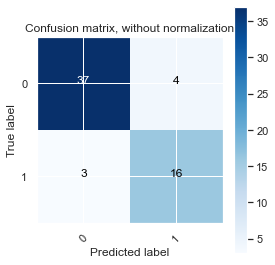

In [51]:
# Make a beautiful plot of the confusion matrix for the validation set prediction

plt.rcParams["figure.figsize"] = [4,4]
classes = [0,1]

#classes,
fig = plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix, without normalization',
                          cmap=plt.cm.Blues)

In [52]:
recall_score(y_valid, predicted_labels_valid) # Calculate the recall of the validation set prediction

0.8421052631578947

In [53]:
precision_score(y_valid, predicted_labels_valid) # Calculate the precision of the validation set prediction

0.8

In [54]:
f1_score(y_valid, predicted_labels_valid) # Calculate the f1_score of the validation set prediction

0.8205128205128205

In [55]:
accuracy_score(y_valid, predicted_labels_valid) # Calculate the accuracy of the validation set prediction

0.8833333333333333

# Precision Recall Curve

In [56]:
# predict probabilities for the validation data
yhat = model.predict_proba(X_valid)

In [57]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [58]:
# calculate the precision-recall curve parameters
precision, recall, thresholds = precision_recall_curve(y_valid, yhat)

In [59]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

In [60]:
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Best Threshold=%f, Precsion=%.3f' % (thresholds[ix], precision[ix]))
print('Best Threshold=%f, Recall=%.3f' % (thresholds[ix], recall[ix]))

Best Threshold=0.695452, F-Score=0.889
Best Threshold=0.695452, Precsion=0.941
Best Threshold=0.695452, Recall=0.842


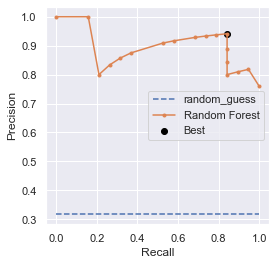

In [61]:
# plot the precision-recall curve for the model
random_guess = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [random_guess,random_guess], linestyle='--', label='random_guess')
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# Test set Prediction

In [62]:
test.shape

(20, 12)

In [63]:
train.shape

(320, 15)

In [64]:
c1 = train.columns
c2 = test.columns
cols =  [item for item in c1 if not item in c2]
for i in cols:
    test[i] = 0

In [65]:
test.shape

(20, 15)

In [66]:
# Separte the explanatory variables and the target variable in the test set
X_test = test[features]
y_test = test[label]

In [67]:
predicted_labels_test_with_threshold = (model.predict_proba(X_test)[:,1]>=0.332714).astype(int)

In [68]:
predicted_labels_test_with_threshold

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1])

In [69]:
# Calculate the confusion matrix of the test set prediction
cm_test = confusion_matrix(y_test, predicted_labels_test_with_threshold)

Confusion matrix, without normalization


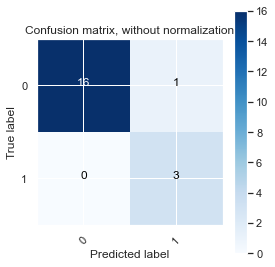

In [70]:
# Make a beautiful plot of the confusion matrix for the test set prediction

plt.rcParams["figure.figsize"] = [4,4]
classes = [0,1]

#classes,
fig = plot_confusion_matrix(cm_test, classes,
                          normalize=False,
                          title='Confusion matrix, without normalization',
                          cmap=plt.cm.Blues)

In [71]:
recall_score(y_test, predicted_labels_test_with_threshold) # Calculate the recall of the test set prediction

1.0

In [72]:
precision_score(y_test, predicted_labels_test_with_threshold) # Calculate the precision of the test set prediction

0.75

In [73]:
f1_score(y_test, predicted_labels_test_with_threshold) # Calculate the f1_score of the test set prediction

0.8571428571428571

In [74]:
accuracy_score(y_test, predicted_labels_test_with_threshold) # Calculate the accuracy of the test set prediction

0.95